In [1]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='d4c1d661-767a-4279-880d-4b61fcefb21d', project_access_token='p-5b846581f7865d7c9f0d725863839e58154c8d2c')
pc = project.project_context


# MARATÓN BEHIND THE CODE 2020

## DESAFÍO 2: TORTUGA CODE

### Introducción

En proyectos de ciencia de datos destinados a construir modelos de *aprendizaje automático*, o aprendizaje estadístico, es muy inusual que los datos iniciales ya estén en el formato ideal para la construcción de modelos. Se requieren varios pasos intermedios de preprocesamiento de datos, como la codificación de variables categóricas, normalización de variables numéricas, tratamiento de datos faltantes, etc. La biblioteca **scikit-learn**, una de las bibliotecas de código abierto más populares para *aprendizaje automático* en el mundo, ya tiene varias funciones integradas para realizar las transformaciones de datos más utilizadas. Sin embargo, en un flujo común de un modelo de aprendizaje automático, es necesario aplicar estas transformaciones al menos dos veces: la primera vez para "entrenar" el modelo, y luego nuevamente cuando se envían nuevos datos como entrada para ser clasificados por este modelo.


### Trabajando scikit-learn

In [2]:
# Primero, realizamos la instalación de scikit-learn
!pip install scikit-learn --upgrade

Requirement already up-to-date: scikit-learn in /opt/conda/envs/Python36/lib/python3.6/site-packages (0.23.2)


In [3]:
# A continuación importaremos varias bibliotecas que se utilizarán:

# Biblioteca para trabajar con JSON
import json

# Biblioteca para realizar solicitudes HTTP
import requests

# Biblioteca para exploración y análisis de datos
import pandas as pd

# Biblioteca con métodos numéricos y representaciones matriciales
import numpy as np


# Paquetes scikit-learn para preprocesamiento de datos
# "SimpleImputer" es una transformación para completar los valores faltantes en conjuntos de datos
from sklearn.impute import SimpleImputer

# Paquetes de scikit-learn para entrenamiento de modelos y construcción de pipelines
# Método para separar el conjunto de datos en muestras de testes y entrenamiento
from sklearn.model_selection import train_test_split
# Método para crear modelos basados en árboles de decisión
from sklearn.tree import DecisionTreeClassifier
# Clase para crear una pipeline de machine-learning
from sklearn.pipeline import Pipeline

# Paquetes scikit-learn para evaluación de modelos
# Métodos para la validación cruzada del modelo creado
from sklearn.model_selection import KFold, cross_validate, cross_val_score, RandomizedSearchCV

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

### Importar  un .csv a tu proyecto en IBM Cloud Pak for Data al Kernel de este notebook

In [4]:
# Primero, importaremos el conjunto de datos proporcionado para el desafío, que ya está incluido en este proyecto.

!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/maratonadev-la/desafio-2-2020/master/Assets/Data/dataset-tortuga-desafio-2.csv
df_training_dataset = pd.read_csv(r'dataset-tortuga-desafio-2.csv')
df_training_dataset.tail()

--2020-09-04 04:16:46--  https://raw.githubusercontent.com/maratonadev-la/desafio-2-2020/master/Assets/Data/dataset-tortuga-desafio-2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.8.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.8.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2031803 (1.9M) [text/plain]
Saving to: ‘dataset-tortuga-desafio-2.csv.1’

100%[======================================>] 2,031,803   --.-K/s   in 0.04s   

2020-09-04 04:16:46 (44.5 MB/s) - ‘dataset-tortuga-desafio-2.csv.1’ saved [2031803/2031803]



,Unnamed: 0,NAME,USER_ID,HOURS_DATASCIENCE,HOURS_BACKEND,HOURS_FRONTEND,NUM_COURSES_BEGINNER_DATASCIENCE,NUM_COURSES_BEGINNER_BACKEND,NUM_COURSES_BEGINNER_FRONTEND,NUM_COURSES_ADVANCED_DATASCIENCE,NUM_COURSES_ADVANCED_BACKEND,NUM_COURSES_ADVANCED_FRONTEND,AVG_SCORE_DATASCIENCE,AVG_SCORE_BACKEND,AVG_SCORE_FRONTEND,PROFILE
19995,20495,Rose Jurado,66754730,0.0,44.0,42.0,8.0,4.0,7.0,3.0,3.0,3.0,74.0,73.0,93.0,advanced_backend
19996,20496,Johnny Jones,6874888,0.0,85.0,63.0,3.0,5.0,0.0,4.0,7.0,3.0,50.0,83.0,94.0,advanced_front_end
19997,20497,Lawrence Givens,83752787,32.0,50.0,22.0,0.0,4.0,0.0,6.0,2.0,3.0,61.0,81.0,75.0,advanced_backend
19998,20498,Betty Diclaudio,45806698,0.0,96.0,69.0,3.0,3.0,3.0,5.0,7.0,4.0,64.0,68.0,68.0,advanced_front_end
19999,20499,Connie Harper,67068866,51.0,24.0,36.0,4.0,2.0,7.0,0.0,0.0,2.0,63.0,61.0,87.0,advanced_data_science


Tenemos 16 columnas presentes en el set de datos proporcionado, 15 de las cuales son variables features (datos de entrada) y una de ellas es una variable target (que queremos que nuestro modelo va a predecir).

Las variables features son:

    Unnamed: 0                          - Esta columna no tiene nombre y debe ser eliminada del dataset
    NAME                                - Nombre del estudiante
    USER_ID                             - Número de identificación del estudiante
    HOURS_DATASCIENCE                   - Número de horas de estudio en Data Science
    HOURS_BACKEND                       - Número de horas de estudio en Web (Back-End)
    HOURS_FRONTEND                      - Número de horas de estudio en Web (Front-End)
    NUM_COURSES_BEGINNER_DATASCIENCE    - Número de cursos de nivel principiante en Data Science completados por el estudiante
    NUM_COURSES_BEGINNER_BACKEND        - Número de cursos de nivel principiante en Web (Back-End) completados por el estudiante
    NUM_COURSES_BEGINNER_FRONTEND       - Número de cursos de nivel principiante en Web (Front-End) completados por el estudiante
    NUM_COURSES_ADVANCED_DATASCIENCE    - Número de cursos de nivel avanzado en Data Science completados por el estudiante
    NUM_COURSES_ADVANCED_BACKEND        - Número de cursos de nivel avanzado en Web (Back-End) completados por el estudiante
    NUM_COURSES_ADVANCED_FRONTEND       - Número de cursos de nivel avanzado en Web (Front-End) completados por el estudiante
    AVG_SCORE_DATASCIENCE               - Promedio acumulado en cursos de Data Science completados por el estudiante
    AVG_SCORE_BACKEND                   - Promedio acumulado en cursos de Web (Back-End) completados por el estudiante
    AVG_SCORE_FRONTEND                  - Promedio acumulado en cursos de Web (Front-End) completados por el estudiante
    
La variable target es:

    PROFILE                             - Perfil de carrera del estudiante (puede ser uno de 6)
    
        - beginner_front_end
        - advanced_front_end
        - beginner_back_end
        - advanced_back_end
        - beginner_data_science
        - advanced_data_science
        
Con un modelo capaz de clasificar a un alumno en una de estas categorías, podemos recomendar contenidos a los alumnos de forma personalizada según las necesidades de cada alumno.

### Explorando los datos proporcionados

Podemos continuar la exploración de los datos proporcionados con la función ``info()``:

In [5]:
df_training_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 16 columns):
Unnamed: 0                          20000 non-null int64
NAME                                20000 non-null object
USER_ID                             20000 non-null int64
HOURS_DATASCIENCE                   19986 non-null float64
HOURS_BACKEND                       19947 non-null float64
HOURS_FRONTEND                      19984 non-null float64
NUM_COURSES_BEGINNER_DATASCIENCE    19974 non-null float64
NUM_COURSES_BEGINNER_BACKEND        19982 non-null float64
NUM_COURSES_BEGINNER_FRONTEND       19961 non-null float64
NUM_COURSES_ADVANCED_DATASCIENCE    19998 non-null float64
NUM_COURSES_ADVANCED_BACKEND        19992 non-null float64
NUM_COURSES_ADVANCED_FRONTEND       19963 non-null float64
AVG_SCORE_DATASCIENCE               19780 non-null float64
AVG_SCORE_BACKEND                   19916 non-null float64
AVG_SCORE_FRONTEND                  19832 non-null float64
PROFILE    

### Visualización (visualizations)

Para ver el conjunto de datos suministrado, podemos usar las bibliotecas ``matplotlib`` y ``seaborn``:

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

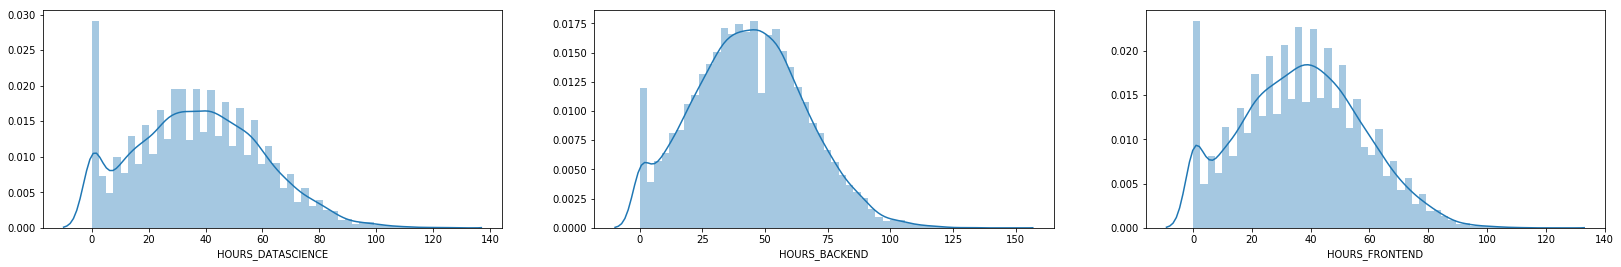

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(28, 4))

sns.distplot(df_training_dataset['HOURS_DATASCIENCE'].dropna(), ax=axes[0])
sns.distplot(df_training_dataset['HOURS_BACKEND'].dropna(), ax=axes[1])
sns.distplot(df_training_dataset['HOURS_FRONTEND'].dropna(), ax=axes[2])

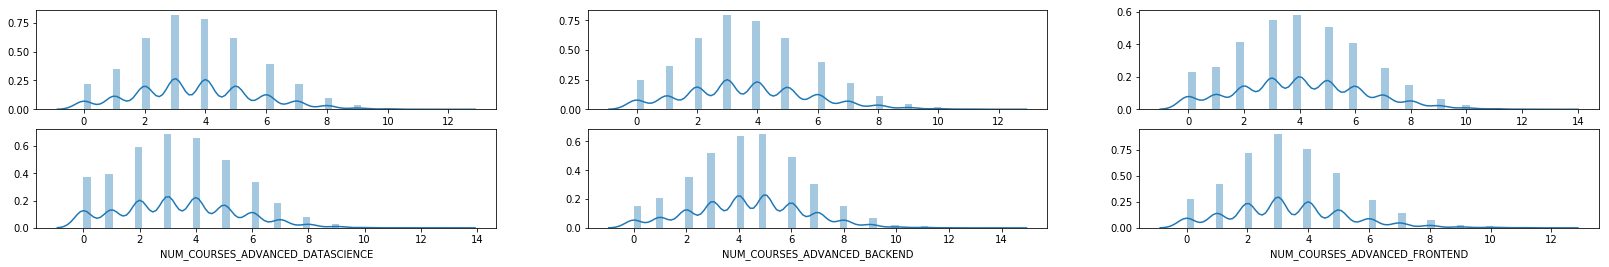

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(28, 4))

sns.distplot(df_training_dataset['NUM_COURSES_BEGINNER_DATASCIENCE'].dropna(), ax=axes[0][0])
sns.distplot(df_training_dataset['NUM_COURSES_BEGINNER_BACKEND'].dropna(), ax=axes[0][1])
sns.distplot(df_training_dataset['NUM_COURSES_BEGINNER_FRONTEND'].dropna(), ax=axes[0][2])
sns.distplot(df_training_dataset['NUM_COURSES_ADVANCED_DATASCIENCE'].dropna(), ax=axes[1][0])
sns.distplot(df_training_dataset['NUM_COURSES_ADVANCED_BACKEND'].dropna(), ax=axes[1][1])
sns.distplot(df_training_dataset['NUM_COURSES_ADVANCED_FRONTEND'].dropna(), ax=axes[1][2])

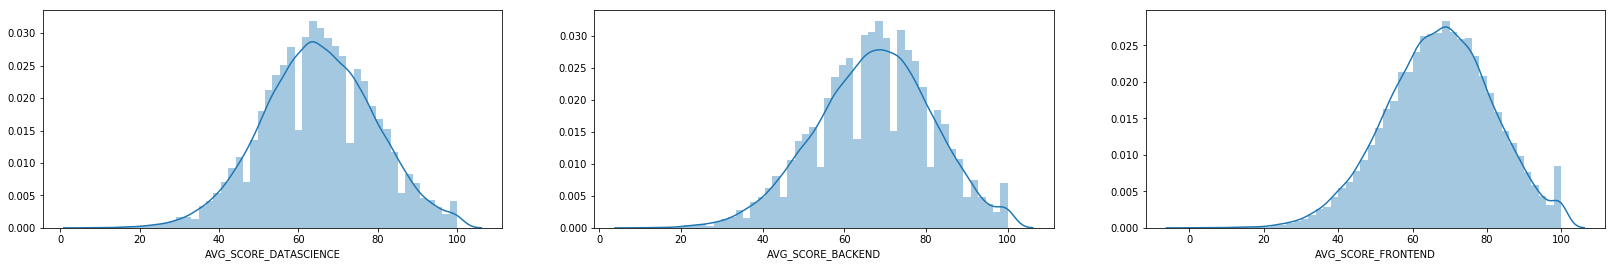

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(28, 4))

sns.distplot(df_training_dataset['AVG_SCORE_DATASCIENCE'].dropna(), ax=axes[0])
sns.distplot(df_training_dataset['AVG_SCORE_BACKEND'].dropna(), ax=axes[1])
sns.distplot(df_training_dataset['AVG_SCORE_FRONTEND'].dropna(), ax=axes[2])

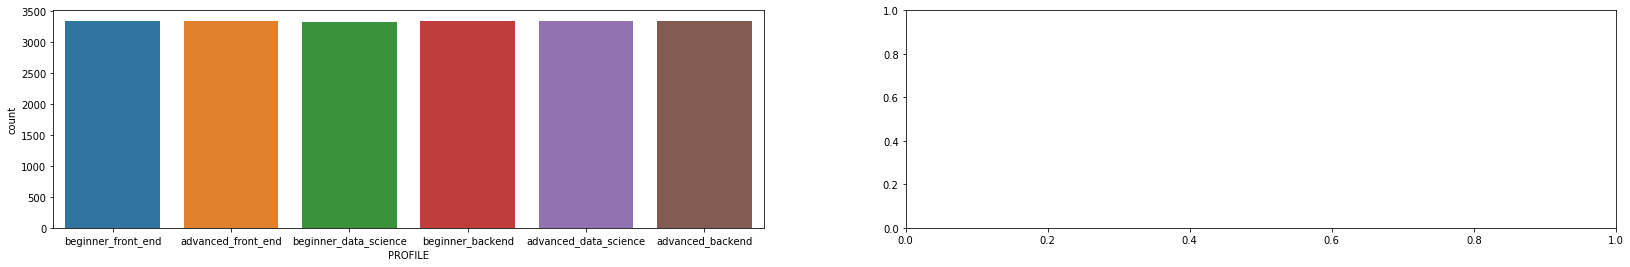

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(28, 4))

sns.countplot(ax=axes[0], x='PROFILE', data=df_training_dataset)

In [11]:
mat_corre = df_training_dataset.corr()
display(mat_corre)

,Unnamed: 0,USER_ID,HOURS_DATASCIENCE,HOURS_BACKEND,HOURS_FRONTEND,NUM_COURSES_BEGINNER_DATASCIENCE,NUM_COURSES_BEGINNER_BACKEND,NUM_COURSES_BEGINNER_FRONTEND,NUM_COURSES_ADVANCED_DATASCIENCE,NUM_COURSES_ADVANCED_BACKEND,NUM_COURSES_ADVANCED_FRONTEND,AVG_SCORE_DATASCIENCE,AVG_SCORE_BACKEND,AVG_SCORE_FRONTEND
Unnamed: 0,1.000000,0.005157,-0.002028,0.008594,0.001815,-0.012366,0.002500,0.001458,0.001930,-0.007515,-0.001563,0.001128,0.005106,0.006853
USER_ID,0.005157,1.000000,-0.001516,0.004521,-0.006331,0.006075,0.000751,0.001496,-0.003448,0.010077,0.007498,0.000067,-0.001028,-0.008334
HOURS_DATASCIENCE,-0.002028,-0.001516,1.000000,0.022285,-0.089033,0.136486,0.125067,0.000017,0.058442,0.073649,-0.109489,-0.301230,-0.242225,0.004830
HOURS_BACKEND,0.008594,0.004521,0.022285,1.000000,-0.035490,0.268036,-0.043361,-0.090044,0.111465,0.024306,0.052282,0.003883,-0.006452,0.007383
HOURS_FRONTEND,0.001815,-0.006331,-0.089033,-0.035490,1.000000,-0.128500,-0.074759,-0.028532,0.057225,-0.032870,-0.053744,-0.184332,0.067357,0.044491
NUM_COURSES_BEGINNER_DATASCIENCE,-0.012366,0.006075,0.136486,0.268036,-0.128500,1.000000,-0.052426,0.238592,0.074982,-0.133970,0.132124,0.020116,0.021273,0.160469
NUM_COURSES_BEGINNER_BACKEND,0.002500,0.000751,0.125067,-0.043361,-0.074759,-0.052426,1.000000,-0.100345,-0.033242,0.058451,-0.154530,0.037070,0.039767,-0.188923
NUM_COURSES_BEGINNER_FRONTEND,0.001458,0.001496,0.000017,-0.090044,-0.028532,0.238592,-0.100345,1.000000,-0.074133,-0.168319,0.135645,-0.078857,0.047987,0.079742
NUM_COURSES_ADVANCED_DATASCIENCE,0.001930,-0.003448,0.058442,0.111465,0.057225,0.074982,-0.033242,-0.074133,1.000000,-0.091480,0.134659,0.089992,0.099666,0.115238
NUM_COURSES_ADVANCED_BACKEND,-0.007515,0.010077,0.073649,0.024306,-0.032870,-0.133970,0.058451,-0.168319,-0.091480,1.000000,-0.143084,-0.003818,-0.198806,-0.114480


### Como se puede ver no existe correlacion entre las variables

In [12]:
umbral_correlacion = 0.6
df_cols = mat_corre.stack().reset_index()
df_cols.columns = ['VariableA','VariableB','correlation']
df_corr = df_cols[(df_cols['correlation']>umbral_correlacion)&(df_cols['correlation']!=1)]
display(df_corr)

,VariableA,VariableB,correlation


### Preprocesamiento de datos

Para el preprocesamiento de los datos, se presentarán en este notebook dos transformaciones básicas, demostrando la construcción de un Pipeline con un modelo funcional. Este Pipeline funcional provisto debe ser mejorado por el participante para que el modelo final alcance la mayor precisión posible, garantizando una mayor puntuación en el desafío. Esta mejora solo se puede realizar en el preprocesamiento de los datos, en la elección de un algoritmo para el entrenamiento de diferentes modelos, o incluso en la alteración del **framework** utilizado (sin embargo, solo se entregará un ejemplo de integración de Watson Machine Learning con *scikit-learn*).

La primera transformación (paso en nuestro Pipeline) será la exclusión de la columna "NOMBRE" de nuestro conjunto de datos, que además de no ser una variable numérica, tampoco es una variable relacionada con el desempeño de los estudiantes en las disciplinas. Hay funciones listas para usar en *scikit-learn* para realizar esta transformación, sin embargo, nuestro ejemplo demostrará cómo crear una transformación personalizada desde cero en scikit-learn. Si lo desea, el participante puede usar este ejemplo para crear otras transformaciones y agregarlas al Pipeline final :)

#### Transformación 1: excluir columnas del conjunto de datos

Para la creación de una transformación de datos personalizada en scikit-learn, es necesario crear una clase con los métodos ``transform`` y ``fit``. En el método de 'transform', se ejecutará la lógica de nuestra transformación.

La siguiente celda muestra el código completo de una transformación ``DropColumns`` para eliminar columnas de un pandas DataFrame.

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin


# All sklearn Transforms must have the `transform` and `fit` methods
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Primero copiamos el dataframe de datos de entrada 'X'
        data = X.copy()
        # Devolvemos un nuevo dataframe de datos sin las columnas no deseadas
        return data.drop(labels=self.columns, axis='columns')

Para aplicar esa transformación en un pandas DataFrame pandas, basta instanciar un objeto *DropColumns* y llamar el método transform().

In [14]:
# Aplicar la transformación ``DropColumns`` al conjunto de datos base
df_training_dataset_2 = DropColumns(columns=["NAME", "Unnamed: 0","USER_ID"]).fit_transform(X=df_training_dataset)

In [15]:
# Ver las columnas del conjunto de datos transformado
print("Columnas del conjunto de datos después de la transformación ``DropColumns``: \n")
print(df_training_dataset_2.columns)

Columnas del conjunto de datos después de la transformación ``DropColumns``: 

Index(['HOURS_DATASCIENCE', 'HOURS_BACKEND', 'HOURS_FRONTEND',
       'NUM_COURSES_BEGINNER_DATASCIENCE', 'NUM_COURSES_BEGINNER_BACKEND',
       'NUM_COURSES_BEGINNER_FRONTEND', 'NUM_COURSES_ADVANCED_DATASCIENCE',
       'NUM_COURSES_ADVANCED_BACKEND', 'NUM_COURSES_ADVANCED_FRONTEND',
       'AVG_SCORE_DATASCIENCE', 'AVG_SCORE_BACKEND', 'AVG_SCORE_FRONTEND',
       'PROFILE'],
      dtype='object')


Tenga en cuenta que la columna "NOMBRE" se ha eliminado y nuestro conjunto de datos ahora solo tiene 14 columnas.

#### Transformación 2: tratamiento de datos faltantes

Para manejar los datos que faltan en nuestro conjunto de datos, ahora usaremos una transformación lista para usar de la biblioteca scikit-learn, llamada **SimpleImputer**.

Esta transformación permite varias estrategias para el tratamiento de datos faltantes. La documentación oficial se puede encontrar en: https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html

En este ejemplo, simplemente haremos cero todos los valores faltantes.

In [16]:
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [17]:
# Ver los datos faltantes del conjunto de datos antes de la primera transformación (df_data_2)
print("Valores nulos antes de la transformación SimpleImputer: \n\n{}\n".format(df_training_dataset_2.isnull().sum(axis = 0)))

Valores nulos antes de la transformación SimpleImputer: 

HOURS_DATASCIENCE                    14
HOURS_BACKEND                        53
HOURS_FRONTEND                       16
NUM_COURSES_BEGINNER_DATASCIENCE     26
NUM_COURSES_BEGINNER_BACKEND         18
NUM_COURSES_BEGINNER_FRONTEND        39
NUM_COURSES_ADVANCED_DATASCIENCE      2
NUM_COURSES_ADVANCED_BACKEND          8
NUM_COURSES_ADVANCED_FRONTEND        37
AVG_SCORE_DATASCIENCE               220
AVG_SCORE_BACKEND                    84
AVG_SCORE_FRONTEND                  168
PROFILE                               0
dtype: int64



In [18]:
# Aplicamos el SimpleImputer ``si`` al conjunto de datos df_data_2 (resultado de la primera transformación)
df_training_dataset_3 = DataFrameImputer().fit_transform(df_training_dataset_2)

In [19]:
# Ver los datos faltantes del conjunto de datos después de la segunda transformación (SimpleImputer) (df_data_3)
print("Valores nulos en el conjunto de datos después de la transformación SimpleImputer: \n\n{}\n".format(df_training_dataset_3.isnull().sum(axis = 0)))

Valores nulos en el conjunto de datos después de la transformación SimpleImputer: 

HOURS_DATASCIENCE                   0
HOURS_BACKEND                       0
HOURS_FRONTEND                      0
NUM_COURSES_BEGINNER_DATASCIENCE    0
NUM_COURSES_BEGINNER_BACKEND        0
NUM_COURSES_BEGINNER_FRONTEND       0
NUM_COURSES_ADVANCED_DATASCIENCE    0
NUM_COURSES_ADVANCED_BACKEND        0
NUM_COURSES_ADVANCED_FRONTEND       0
AVG_SCORE_DATASCIENCE               0
AVG_SCORE_BACKEND                   0
AVG_SCORE_FRONTEND                  0
PROFILE                             0
dtype: int64



In [20]:
class DataScaleImputer(TransformerMixin):

    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Primero copiamos el dataframe de datos de entrada 'X'
        data = X.copy()
        num_features = data.columns.drop(self.columns)
        transformer = ColumnTransformer(transformers=[('scaler', StandardScaler(),num_features)])
        X_transform = transformer.fit_transform(data)
        X_imputed_df = pd.DataFrame(data = X_transform, columns = num_features.values)
        X_imputed_df[self.columns] = data[self.columns]
        return X_imputed_df

In [21]:
df_training_dataset_4 = DataScaleImputer(columns=['PROFILE']).fit_transform(df_training_dataset_3)

Tenga en cuenta que ya no tenemos valores perdidos en nuestro conjunto de datos :)

Vale la pena señalar que cambiar los valores perdidos por 0 no siempre es la mejor estrategia. Se anima al participante a estudiar e implementar diferentes estrategias para tratar los valores perdidos para mejorar su modelo y mejorar su puntuación final.

### Entrenando un modelo de clasificación

Una vez finalizado el preprocesamiento, ya tenemos el conjunto de datos en el formato necesario para entrenar nuestro modelo:

In [22]:
df_training_dataset_4.head()

,HOURS_DATASCIENCE,HOURS_BACKEND,HOURS_FRONTEND,NUM_COURSES_BEGINNER_DATASCIENCE,NUM_COURSES_BEGINNER_BACKEND,NUM_COURSES_BEGINNER_FRONTEND,NUM_COURSES_ADVANCED_DATASCIENCE,NUM_COURSES_ADVANCED_BACKEND,NUM_COURSES_ADVANCED_FRONTEND,AVG_SCORE_DATASCIENCE,AVG_SCORE_BACKEND,AVG_SCORE_FRONTEND,PROFILE
0,-1.365351,-0.203614,-0.385616,-0.849179,0.135590,-1.764960,-0.661751,0.303395,-1.695828,1.364471,0.476967,0.000000,beginner_front_end
1,-0.248602,-1.948013,0.343190,-0.849179,-1.768388,-1.764960,-1.609044,0.303395,-1.695828,0.139093,-1.567540,0.000000,beginner_front_end
2,0.332108,-1.948013,1.071995,-1.849031,0.611585,-0.021055,-1.609044,-0.159336,-1.192291,0.000000,-0.933038,-1.399362,advanced_front_end
3,-0.069922,-1.098178,-0.434203,-1.849031,0.611585,1.286874,-1.609044,0.303395,-0.185216,0.000000,0.265466,1.520212,beginner_data_science
4,1.046827,1.540784,0.051667,1.150526,3.467552,-1.764960,0.285543,-0.622067,-1.695828,0.067012,1.252469,0.000000,advanced_front_end


En el ejemplo proporcionado, usaremos todas las columnas, excepto la columna **Profile** como *feautres* (variables de entrada).

La variable **Profile** será la variable objetivo del modelo, como se describe en la declaración de desafío.

#### Definición de features del modelo

In [23]:
# Definición de las columnas que seran features (Notese que la columna NOMBRE no esta presente)
features = [
    "HOURS_DATASCIENCE", "HOURS_BACKEND", "HOURS_FRONTEND",
    "NUM_COURSES_BEGINNER_DATASCIENCE", "NUM_COURSES_BEGINNER_BACKEND", "NUM_COURSES_BEGINNER_FRONTEND",
    "NUM_COURSES_ADVANCED_DATASCIENCE", "NUM_COURSES_ADVANCED_BACKEND", "NUM_COURSES_ADVANCED_FRONTEND",
    "AVG_SCORE_DATASCIENCE", "AVG_SCORE_BACKEND", "AVG_SCORE_FRONTEND"
]

# Definición de variable objetivo
target = ['PROFILE']
X = df_training_dataset_4[features]
y = df_training_dataset_4[target]

Las variables (X e y):

In [24]:
X.head()

,HOURS_DATASCIENCE,HOURS_BACKEND,HOURS_FRONTEND,NUM_COURSES_BEGINNER_DATASCIENCE,NUM_COURSES_BEGINNER_BACKEND,NUM_COURSES_BEGINNER_FRONTEND,NUM_COURSES_ADVANCED_DATASCIENCE,NUM_COURSES_ADVANCED_BACKEND,NUM_COURSES_ADVANCED_FRONTEND,AVG_SCORE_DATASCIENCE,AVG_SCORE_BACKEND,AVG_SCORE_FRONTEND
0,-1.365351,-0.203614,-0.385616,-0.849179,0.135590,-1.764960,-0.661751,0.303395,-1.695828,1.364471,0.476967,0.000000
1,-0.248602,-1.948013,0.343190,-0.849179,-1.768388,-1.764960,-1.609044,0.303395,-1.695828,0.139093,-1.567540,0.000000
2,0.332108,-1.948013,1.071995,-1.849031,0.611585,-0.021055,-1.609044,-0.159336,-1.192291,0.000000,-0.933038,-1.399362
3,-0.069922,-1.098178,-0.434203,-1.849031,0.611585,1.286874,-1.609044,0.303395,-0.185216,0.000000,0.265466,1.520212
4,1.046827,1.540784,0.051667,1.150526,3.467552,-1.764960,0.285543,-0.622067,-1.695828,0.067012,1.252469,0.000000


In [25]:
y.head()

,PROFILE
0,beginner_front_end
1,beginner_front_end
2,advanced_front_end
3,beginner_data_science
4,advanced_front_end


#### Separar el conjunto de datos en un conjunto de entrenamiento y un conjunto de prueba

Separaremos el conjunto de datos provisto en dos grupos: uno para entrenar nuestro modelo y otro para probar el resultado a través de una prueba ciega. La separación del conjunto de datos se puede hacer fácilmente con el método *train_test_split ()* de scikit-learn:

In [26]:
# Separación de datos en conjunto de entrenamiento y conjunto de pruebas
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=337)

## Creando un modelo ensamble - Entrenando varios modelos de clasificación previo Tunnig ver sección al final

In [27]:
semilla_aleatoria = 1234
class_SVC = SVC(C=1000,kernel='rbf',random_state=semilla_aleatoria,gamma='auto')
class_RFO = RandomForestClassifier(n_estimators=800, min_samples_split=2,min_samples_leaf= 1,max_features= 'auto',max_depth=30, bootstrap=True, random_state=semilla_aleatoria)
class_RNN = MLPClassifier(solver= 'sgd', max_iter= 480, learning_rate= 'adaptive', hidden_layer_sizes= (144, 144, 12), alpha= 0.05, activation='tanh', random_state=semilla_aleatoria)
dtc_model = VotingClassifier(estimators=[('SVC', class_SVC), ('RFOR', class_RFO),('RNN',class_RNN)], voting='hard')

Material teórico sobre árboles de decisión en la documentación oficial de scikit-learn: https://scikit-learn.org/stable/modules/tree.html

Una guía para principiantes del mundo del aprendizaje automático: https://developer.ibm.com/es/patterns/use-icp4d-to-build-the-machine-learning-model-for-return-propensity/

#### Ejecucion del entrenamiento del árbol de descisión 

In [28]:
# Entrenamiento de modelos (llamado método *fit ()* con conjuntos de entrenamiento)
dtc_model.fit(
    X_train,
    y_train
)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (480) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


VotingClassifier(estimators=[('SVC',
                              SVC(C=1000, gamma='auto', random_state=1234)),
                             ('RFOR',
                              RandomForestClassifier(max_depth=30,
                                                     n_estimators=800,
                                                     random_state=1234)),
                             ('RNN',
                              MLPClassifier(activation='tanh', alpha=0.05,
                                            hidden_layer_sizes=(144, 144, 12),
                                            learning_rate='adaptive',
                                            max_iter=480, random_state=1234,
                                            solver='sgd'))])

#### Ejecución de predicciones y evaluación del modelo creado

In [29]:
# Realización de una prueba a ciegas en el modelo creado
y_pred = dtc_model.predict(X_test)

In [30]:
print(y_pred)

['advanced_front_end' 'advanced_data_science' 'beginner_data_science' ...
 'beginner_backend' 'advanced_backend' 'beginner_front_end']


In [31]:
from sklearn.metrics import accuracy_score

# Precisión lograda por el árbol de decisiones
print("model score: %.3f" % dtc_model.score(X_test, y_test))
print("Exactitud: {}%".format(100*round(accuracy_score(y_test, y_pred), 2)))

model score: 0.959
Exactitud: 96.0%


### Matriz de confusion

In [32]:
display(confusion_matrix(y_test,y_pred))
class_report=classification_report(y_test,y_pred)
print(class_report)     

array([[959,  11,   0,   1,   1,   5],
       [ 15, 937,  10,   8,  14,   4],
       [ 10,   8, 990,   9,   6,  10],
       [ 13,  15,  10, 906,   8,   7],
       [  3,  10,   8,  13, 970,   3],
       [  7,   8,  15,  14,   2, 990]])

                       precision    recall  f1-score   support

     advanced_backend       0.95      0.98      0.97       977
advanced_data_science       0.95      0.95      0.95       988
   advanced_front_end       0.96      0.96      0.96      1033
     beginner_backend       0.95      0.94      0.95       959
beginner_data_science       0.97      0.96      0.97      1007
   beginner_front_end       0.97      0.96      0.96      1036

             accuracy                           0.96      6000
            macro avg       0.96      0.96      0.96      6000
         weighted avg       0.96      0.96      0.96      6000



In [33]:
def graficar_accuracy_scores(estimator, train_x, train_y,test_x,test_y,nparts=5,jobs=None):
    kfold = KFold(n_splits=nparts,shuffle=True, random_state=semilla_aleatoria)
    fig,axes = plt.subplots(figsize=(7, 3))
    axes.set_title("Ratio de éxito(Accuracy)/Nro. Fold")
    axes.set_xlabel("Nro. Fold")
    axes.set_ylabel("Accuracy")    
    train_scores = cross_val_score(estimator, train_x,train_y, cv = kfold, n_jobs=jobs, scoring="accuracy")
    test_scores = cross_val_score(estimator, test_x, test_y, cv = kfold, n_jobs=jobs, scoring="accuracy")        
    train_sizes = range(1,nparts+1,1)    
    axes.grid()    
    axes.plot(train_sizes, train_scores, 'o-', color="r",label="Datos Entrenamiento")
    axes.plot(train_sizes, test_scores, 'o-', color="g",label="Validacion Cruzada")
    axes.legend(loc="best")
    return train_scores

array([0.95321429, 0.95607143, 0.95071429, 0.95535714, 0.95535714])

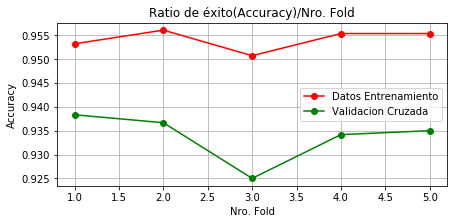

In [34]:
graficar_accuracy_scores(dtc_model,X_train,y_train,X_test,y_test,nparts=5,jobs=2)

## Tunning de los Hiperparametros de los Modelos
## Correr únicamente si se desea hacer una mejora en los hiper parametros
##### Cambiar esta celda a CODE

##### Cambiar esta celda a CODE
parameter_space = {'SVC__C':[0.1, 1, 10, 100, 1000],
    'SVC__kernel' : ['linear', 'rbf', 'poly'],
    'RFOR__n_estimators':  [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
    'RFOR__max_features': ['auto', 'sqrt'],
    'RFOR__max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
    'RFOR__min_samples_split': [2, 5, 10],
    'RFOR__min_samples_leaf':  [1, 2, 4],
    'RFOR__bootstrap': [True, False],        
    'RNN__hidden_layer_sizes': [(12,12,6),(144,144,12),(12,144,6),(24,432,12),(24,144,24)],
    'RNN__activation': ['tanh', 'relu'],
    'RNN__solver': ['sgd', 'adam'],
    'RNN__alpha': [0.0001, 0.05,0.02],
    'RNN__max_iter': [int(x) for x in np.linspace(start = 100, stop = 2000, num = 6)],              
    'RNN__learning_rate': ['constant','adaptive'],   
}

clf_CV = RandomizedSearchCV(dtc_model, parameter_space, n_jobs=-1, cv=5)
clf_CV.fit(X_train, y_train) 
print('Los parametros optimizados son:\n', clf_CV.best_params_)

<hr>

## Puntuación de los datos necesarios para entregar la solución

Como entrega de su solución, esperamos que los resultados se clasifiquen en el siguiente dataset llamado "to_be_scored_tortuga_fix.csv":

### Descarga la "hoja de evaluación"

In [35]:
!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/vanderlei-test/dataset-tortuga/master/to_be_scored_tortuga_fix.csv
df_to_be_scored = pd.read_csv(r'to_be_scored_tortuga_fix.csv')
df_to_be_scored.tail()

--2020-09-04 04:31:16--  https://raw.githubusercontent.com/vanderlei-test/dataset-tortuga/master/to_be_scored_tortuga_fix.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.8.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.8.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29095 (28K) [text/plain]
Saving to: ‘to_be_scored_tortuga_fix.csv.1’

100%[======================================>] 29,095      --.-K/s   in 0.001s  

2020-09-04 04:31:16 (21.3 MB/s) - ‘to_be_scored_tortuga_fix.csv.1’ saved [29095/29095]



,Unnamed: 0,NAME,USER_ID,HOURS_DATASCIENCE,HOURS_BACKEND,HOURS_FRONTEND,NUM_COURSES_BEGINNER_DATASCIENCE,NUM_COURSES_BEGINNER_BACKEND,NUM_COURSES_BEGINNER_FRONTEND,NUM_COURSES_ADVANCED_DATASCIENCE,NUM_COURSES_ADVANCED_BACKEND,NUM_COURSES_ADVANCED_FRONTEND,AVG_SCORE_DATASCIENCE,AVG_SCORE_BACKEND,AVG_SCORE_FRONTEND
495,506,Eileen Finley,1147648,0,56,11,2,1,8,5,2,6,80,93,35
496,507,Cedric Buss,33729943,50,53,5,4,1,4,8,4,4,59,59,50
497,508,James Ray,62724217,35,35,63,3,0,0,5,3,5,35,54,59
498,509,Lauren Vega,71562358,42,4,58,6,6,5,7,7,5,78,59,79
499,510,Joshua Brown,48754463,6,47,39,5,2,8,5,4,9,88,83,61


# ¡Atención!

El Dataframe ``to_be_scored_tortuga`` es su "hoja de evaluación". Tenga en cuenta que la columna "PROFILE" hace falta en este dataset de evaluación, por lo que no se puede usar para entrenar modelos de aprendizaje supervisado.

In [36]:
df_to_be_scored.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 15 columns):
Unnamed: 0                          500 non-null int64
NAME                                500 non-null object
USER_ID                             500 non-null int64
HOURS_DATASCIENCE                   500 non-null int64
HOURS_BACKEND                       500 non-null int64
HOURS_FRONTEND                      500 non-null int64
NUM_COURSES_BEGINNER_DATASCIENCE    500 non-null int64
NUM_COURSES_BEGINNER_BACKEND        500 non-null int64
NUM_COURSES_BEGINNER_FRONTEND       500 non-null int64
NUM_COURSES_ADVANCED_DATASCIENCE    500 non-null int64
NUM_COURSES_ADVANCED_BACKEND        500 non-null int64
NUM_COURSES_ADVANCED_FRONTEND       500 non-null int64
AVG_SCORE_DATASCIENCE               500 non-null int64
AVG_SCORE_BACKEND                   500 non-null int64
AVG_SCORE_FRONTEND                  500 non-null int64
dtypes: int64(14), object(1)
memory usage: 58.7+ KB


<hr>

# ¡Atención!

# Para aplicar su modelo y clasificar la hoja de evaluación, primero debe aplicar las mismas transformaciones de columnas que aplicó al conjunto de datos de entrenamiento.

# No elimine ni agregue líneas a la hoja de respuestas.

# No cambie el orden de las líneas en la hoja de respuestas.

# Al final, se deben clasificar las 500 entradas, con los valores proporcionados en la columna "target"

<hr>

En la celda de abajo, repetimos rápidamente los mismos pasos de preprocesamiento usados ​​en el ejemplo dado con el árbol de decisiones

In [37]:
df_to_be_scored_2 = DropColumns(columns=["NAME", "Unnamed: 0","USER_ID"]).fit_transform(df_to_be_scored) 
df_to_be_scored_3 = DataFrameImputer().fit_transform(df_to_be_scored_2) 
df_to_be_scored_4 = DataScaleImputer(columns=[]).fit_transform(df_to_be_scored_3)

In [38]:
# Realización de una prueba a ciegas en el modelo creado
y_pred = dtc_model.predict(df_to_be_scored_4)

In [39]:
# Agregando las respuestas en la columna "target"
df_to_be_scored_4['target'] = y_pred
df_to_be_scored_4.tail()

,HOURS_DATASCIENCE,HOURS_BACKEND,HOURS_FRONTEND,NUM_COURSES_BEGINNER_DATASCIENCE,NUM_COURSES_BEGINNER_BACKEND,NUM_COURSES_BEGINNER_FRONTEND,NUM_COURSES_ADVANCED_DATASCIENCE,NUM_COURSES_ADVANCED_BACKEND,NUM_COURSES_ADVANCED_FRONTEND,AVG_SCORE_DATASCIENCE,AVG_SCORE_BACKEND,AVG_SCORE_FRONTEND,target
495,-1.647172,0.509582,-1.324561,-0.853810,-1.299199,1.650906,0.794263,-1.099887,1.439142,1.062845,1.876077,-2.186415,advanced_backend
496,0.537754,0.373934,-1.633918,0.189968,-1.299199,-0.018362,2.245413,-0.142631,0.387138,-0.438147,-0.538619,-1.151834,advanced_backend
497,-0.117724,-0.439950,1.356528,-0.331921,-1.773705,-1.687630,0.794263,-0.621259,0.913140,-2.153566,-0.893722,-0.531085,beginner_data_science
498,0.188166,-1.841639,1.098731,1.233745,1.073334,0.398955,1.761696,1.293253,0.913140,0.919893,-0.538619,0.848357,beginner_front_end
499,-1.384981,0.102640,0.119102,0.711856,-0.824692,1.650906,0.794263,-0.142631,3.017149,1.634651,1.165872,-0.393141,advanced_backend


### Guardar la hoja de respuestas como un archivo .csv para enviar
**SI YA TIENE UN DATA ASSET CON EL NOMBRE `results.csv` EN ESTE PROYECTO O EN OTRO PROYECTO DE WATSON STUDIO DEBE BORRAR EL ARCHIVO ANTES DE CORRER LA SIGUIENTE CELDA O TENDRA EL ERROR: _RuntimeError: File 'results.csv' already exists in storage._**

In [41]:
project.save_data(file_name="results.csv", data=df_to_be_scored_4.to_csv(index=False))

{'file_name': 'results.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'btctortugacode-donotdelete-pr-otvb2uj4rjjkyp',
 'asset_id': 'e3a2717d-5ba2-41a6-8dd1-fd20686924b0'}

# Atención

# La ejecución de la celda anterior creará un nuevo "data asset" en su proyecto de Watson Studio. Deberá descargar este archivo junto con este cuaderno y crear un archivo zip con **results.csv** y **notebook.ipynb** para enviarlo. (los archivos deben tener este nombre)

<hr>

## ¡Felicitaciones!

Si ya está satisfecho con su solución, vaya a la página siguiente y envíe los archivos necesarios para su envío.

# https://tortuga.maratona.dev